In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
import seaborn as sns


In [4]:
def make_grid(df):
    m = max(df["length"])
    df["score_max"] = df["score"].apply(lambda x: np.max(x))
    mx = max(df["score_max"])
    mx_pad_length = 0.05
    df.drop(columns = ["score_max"])
    df["score_processed"] = df["score"].apply(lambda x: np.append(x, -mx))
    grid = df["score_processed"].apply(lambda x: np.pad(x, (0, m - (len(x)-1))))
    df = df.drop(columns = ["score_processed"])
    grid = np.stack(grid)
    return grid

In [37]:
# get IDs 
ids_table = pd.read_csv("all_gtf_merged_non_annotated_buffered.gtf.ids.csv", names = ["id", "transcript_id"])

# let's load some big data...
tss = pd.read_table("../../data/pytss_results/tss.csv", sep = "\t", names = ["id", "seq", "length", "score"])
tss["score"] = tss["score"].apply(lambda x: np.array(eval(x)))
# add transcript_ids
tss = tss.merge(ids_table, on ="id")

polyA = pd.read_table("../../data/pytss_results/polya.csv", sep = "\t", names = ["id", "seq", "length", "score"])
polyA["score"] = polyA["score"].apply(lambda x: np.array(eval(x)))
# add transcript_ids
polyA = polyA.merge(ids_table, on ="id")

/Users/NoahHK/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<AxesSubplot:>

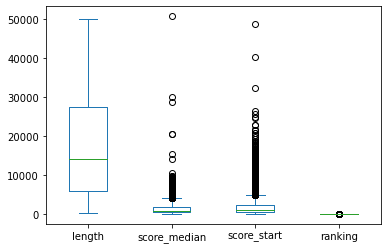

In [145]:
tss.plot.box()

In [731]:
# ----------------------------------------------------------------
#   Apply log2(MeanFC) to TSS
# ----------------------------------------------------------------
buffer_into_transcript = 100

tss["score_mean"] = tss["score"].apply(np.mean)
tss["score_start"] = tss["score"].apply(lambda x: np.mean(x[:500+buffer_into_transcript]))
tss["ranking"] = tss["score_start"] / tss["score_mean"]
tss["ranking"] = tss.ranking.apply(np.log2)

tss[["id", "ranking"]].to_csv("tss_rankings.csv", index = False)

In [732]:
# ----------------------------------------------------------------
#   Apply log2(MeanFC) to polyA
# ----------------------------------------------------------------

polyA["score_mean"] = polyA["score"].apply(np.mean)
polyA["score_start"] = polyA["score"].apply(lambda x: np.mean(x[len(x)-500-buffer_into_transcript-1:]))
polyA["ranking"] = polyA["score_start"] / polyA["score_mean"]
polyA["ranking"] = polyA.ranking.apply(np.log2)

polyA[["id", "ranking"]].to_csv("polyA_rankings.csv", index = False)

In [426]:
# sort by ranking
tss = tss.sort_values(["ranking"], ascending = False).reset_index(drop=True)
polyA = polyA.sort_values(["ranking"], ascending = False).reset_index(drop=True)


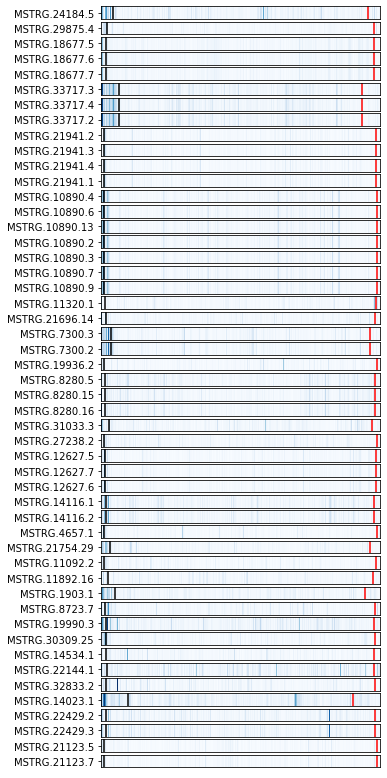

In [428]:
n = 50
offset = 100
fig, axs = plt.subplots(n, figsize =(5,14))

buffer = 500 # since we buffered symmetrically with 500bp

for idx in range(n):
    i = idx + offset
    scores = tss["score"][i]
    id = tss["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Blues")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "red")

# fig.colorbar(c)

In [ ]:
# browse through and select some that ranked high, some that ranked low, well - the ranking does at least visually not inform very well...
to_plot = """714.1
8291.12
346731.1
14638.7
33074.3
9942.7
2775.3
31286.1
16095.2
23489.5
1587.4""".split("\n")
to_plot = [f"MSTRG.{i}" for i in to_plot]


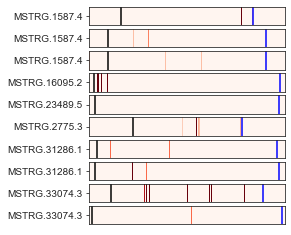

In [691]:
# Plot mean of feature vs mean overall 
# we start with the smaller dataset

n = 10
offset = 0
fig, axs = plt.subplots(n, figsize =(3.5,4))

sns.set_style("ticks")

buffer = 500 # since we buffered symmetrically with 500bp
subset = polyA.query(f"transcript_id in {to_plot}").reset_index()
subset = subset.sort_values("transcript_id").reset_index()
for idx in range(n):
    i = idx + offset
    scores = subset["score"][i]
    id = subset["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Reds")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "blue")

fig.savefig("../Plots/polya_maps.jpg", dpi = 1000, bbox_inches = "tight")

final_subset = list(subset["transcript_id"])

# fig.colorbar(c)

In [695]:
n = 10
offset = 0
fig, axs = plt.subplots(n, figsize =(3.5,4))

buffer = 500 # since we buffered symmetrically with 500bp
subset = tss.query(f"transcript_id in {to_plot}").reset_index()
subset = tss.query(f"transcript_id in {final_subset}").reset_index()
subset = subset.sort_values("transcript_id").reset_index()


for idx in range(n):
    i = idx + offset
    scores = subset["score"][i]
    id = subset["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Blues")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "red")

fig.savefig("../Plots/tss_maps.jpg", dpi = 1000, bbox_inches = "tight")

# fig.colorbar(c)

In [ ]:
# define what a good start annotation is vs a bad one

tss["good_start"] = tss["score_start"] > 1.5 * tss["score_mean"]
tss["bad_start"] = tss["score_start"] < 0.75 * tss["score_mean"]

tss

[None, None]

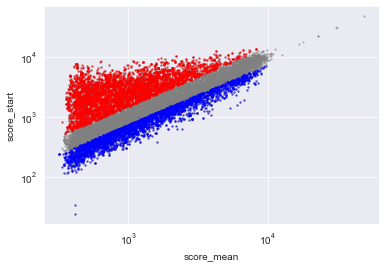

In [736]:

fig, ax = plt.subplots()

tss.plot.scatter(x = "score_mean", y = "score_start", c = "gray", alpha = 0.4, s = 2, ax = ax )
tss.query("good_start == True").plot.scatter(x = "score_mean", y = "score_start", c = "red", alpha = 0.4, s = 2, ax = ax )
tss.query("bad_start == True").plot.scatter(x = "score_mean", y = "score_start", c = "blue", alpha = 0.4, s = 2, ax = ax )

ax.set(xscale = "log", yscale = "log")

[None, None]

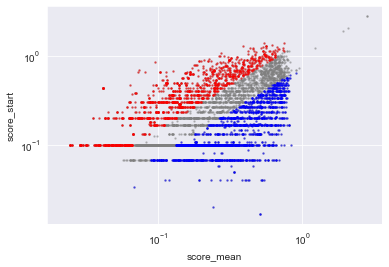

In [737]:
# we keep the good_start name even though now its an end...
fig, ax = plt.subplots()
polyA["good_start"] = polyA["score_start"] > 1.5 * polyA["score_mean"]
polyA["bad_start"] = polyA["score_start"] < 0.75 * polyA["score_mean"]

polyA.plot.scatter(x = "score_mean", y = "score_start", c = "gray", alpha = 0.4, s = 2, ax = ax )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
polyA.query("good_start == True").plot.scatter(x = "score_mean", y = "score_start", c = "red", alpha = 0.4, s = 2, ax = ax )
polyA.query("bad_start == True").plot.scatter(x = "score_mean", y = "score_start", c = "blue", alpha = 0.4, s = 2, ax = ax )

ax.set(xscale = "log", yscale = "log")

<AxesSubplot:>

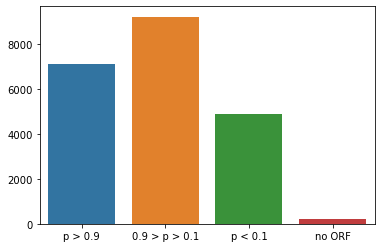

In [640]:
# also load the CPAT data to include in the figure
# read CPAT results
cpat_results = pd.read_table("../../data/CPAT/CPAT.ORF_prob.best.tsv")

upper_threshold = 0.9
lower_threshold = 0.1

labels = [
            f"p > {upper_threshold}", 
            f"{upper_threshold} > p > {lower_threshold}",
            f"p < {lower_threshold}",
]

prop_classification = lambda x: "0" if x > upper_threshold else ("1" if upper_threshold > x > lower_threshold else "2" )

cpat_results["label"] = cpat_results["Coding_prob"].apply(prop_classification)


fig, ax = plt.subplots()

# cpat_results.plot.scatter(x = "Fickett", y = "Coding_prob", ax = ax, alpha = cpat_results["Coding_prob"], c = "lightgray")
# sns.scatterplot(data = subset, x = "ID", y = "Coding_prob", hue = "ORF_strand", ax = ax, alpha = 0.5)
# subset.plot.scatter(x = "Fickett", y = "Coding_prob", ax = ax, c = "blue", alpha = 0.5)

# get number of transcripts without identifiyable ORF
with open("../../data/CPAT/CPAT.no_ORF.txt", "r") as f: 
    no_orfs = len(f.readlines())

# labels = sorted(list(set(cpat_results["label"])), key = lambda x: float(x[-1]), reverse = True)
counts = [len(cpat_results.query(f"label == '{i}'")) for i in range(len(labels))]

counts.append(no_orfs)
labels.append("no ORF")

novel_summary_df = pd.DataFrame(dict(
                                    label = labels, 
                                    count = counts,
                                ))

sns.barplot( 
            x = labels, 
            y = counts, 
            label = labels 
        )

# ax.set(xticks=[])

In [727]:
novel_summary_df

label  count
0        p > 0.9   7099
1  0.9 > p > 0.1   9219
2        p < 0.1   4874
3         no ORF    201

In [711]:


def add_subplot_label(idx, subplot, start_character, **kwargs):
    """
    Adds A B C ... to upper left corner of a subplot...
    """
    offset = kwargs.pop("offset", (0,0))
    fontsize = kwargs.pop("fontsize", 12)
    label = kwargs.pop("label", None)

    subplot_label = chr(ord(start_character)+idx) if label is None else label
    xoff, yoff = offset

    subplot.annotate(
                xy = (-0.1+xoff,1.03+yoff), 
                text = subplot_label, 
                xycoords = "axes fraction",
                weight = "bold", 
                fontsize = fontsize
            )
import matplotlib as mpl


In [730]:
# =================================================================
#   Assemble a little figure for these ... - we will manually add the sequence heatmaps later...
# =================================================================

fig = plt.figure(figsize = (15, 5))

grid = fig.add_gridspec(2, 10)

# ax_mapped_reads = fig.add_subplot(grid[:, 0])
ax_cpat = fig.add_subplot(grid[0, :3])
ax_scatter_tss = fig.add_subplot(grid[0, 3:6])
ax_scatter_polya = fig.add_subplot(grid[1, 3:6])
ax_maps_tss = fig.add_subplot(grid[0, 6:])
ax_maps_polya = fig.add_subplot(grid[1, 6:])


# ----------------------------------------------------------------
# TSS Scatter
# ----------------------------------------------------------------

tss.plot.scatter(x = "total_mean", y = "start_mean", c = "gray", alpha = 0.4, s = 2, ax = ax_scatter_tss )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
tss.query("good_start == True").plot.scatter(x = "total_mean", y = "start_mean", c = "red", alpha = 0.4, s = 2, ax = ax_scatter_tss )
tss.query("bad_start == True").plot.scatter(x = "total_mean", y = "start_mean", c = "blue", alpha = 0.4, s = 2, ax = ax_scatter_tss )
ax.set(xlim = (0, 15000), ylim = (0, 15000))

ax_scatter_tss.set(xlabel = "mean overall", ylabel = "mean start region", xscale = "log", yscale = "log")

# ----------------------------------------------------------------
# PolyA Scatter
# ----------------------------------------------------------------

polyA.plot.scatter(x = "score_median", y = "score_start", c = "gray", alpha = 0.1, s = 2, ax = ax_scatter_polya, style = 'seaborn-darkgrid' )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
polyA.query("good_start == True").plot.scatter(x = "score_median", y = "score_start", c = "red", alpha = 0.4, s = 2, ax = ax_scatter_polya, style = 'seaborn-darkgrid' )
polyA.query("bad_start == True").plot.scatter(x = "score_median", y = "score_start", c = "blue", alpha = 0.4, s = 2, ax = ax_scatter_polya, style = 'seaborn-darkgrid' )

ax_scatter_polya.set(xlabel = "mean overall", ylabel = "mean end region", xscale = "log", yscale = "log")

# ----------------------------------------------------------------
#  CPAT
# ----------------------------------------------------------------

sns.set_style("darkgrid")

novel_summary_df.plot.bar( 
                            ax = ax_cpat,
                            x = "label", 
                            y = "count", 
                            color = ["xkcd:evergreen", "xkcd:spruce", "xkcd:viridian", "xkcd:pale teal"],
                            alpha = 0.7,
                        )
plt.setp( ax_cpat.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor") 
ax_cpat.legend().remove()
ax_cpat.set(xlabel = "")
ax_cpat.axes.spines["left"].set_visible(True)

ax_cpat.axes.spines["bottom"].set_visible(True)

# ----------------------------------------------------------------
#  Maps (just loaded as images)
# ----------------------------------------------------------------

# ax_maps_tss.imshow(
#     plt.imread("../Plots/tss_maps.jpg")
# )

# ax_maps_polya.imshow(
#     plt.imread("../Plots/polya_maps.jpg")
# )

for i in [ax_maps_tss, ax_maps_polya]:
    i.set_xticks([])
    i.set_yticks([])
    i.axes.spines["left"].set_visible(False)
    i.axes.spines["right"].set_visible(False)
    i.axes.spines["top"].set_visible(False)
    i.axes.spines["bottom"].set_visible(False)

idx = 0
for i in [ax_cpat, ax_scatter_tss, ax_scatter_polya, ax_maps_tss, ax_maps_polya]:
    add_subplot_label(idx, i, "A", fontsize = 16)
    idx += 1

fig.savefig("../Plots/novels_stuff.svg")
plt.tight_layout(w_pad = 2)

/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/1157073346.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim = (0, 15000), ylim = (0, 15000))
/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/1157073346.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim = (0, 15000), ylim = (0, 15000))
